In [ ]:
import pandas as pd

df = pd.read_csv(r"products.csv")
# Keep only rows with Price > 0
df = df.drop_duplicates().reset_index(drop=True)

df.to_csv("filterNewAkakce.csv",index=False)
print(f"Original rows: {len(df)}")

In [ ]:
import pandas as pd

df = pd.read_csv(r"C:\Users\pc\Desktop\AIbazaar\AIBazaar\AI\utils\filterPhone.csv")
print("İlk 10 satır:")
print(df.head(10))
print("\n" + "=" * 50 + "\n")

columns_to_concat = [
    "storage",
    "ram",
    "phone_brand",
    "phone_model",  
    "dimensions",
    "display_size",
    "display_resolution",
    "os",
    "battery",
    "video",
    "chipset",
    "cpu",
    "gpu",
    "ppi_density",
]

result_df = pd.DataFrame(columns=["productID", "Product Name", "description"])

for index, row in df.iterrows():
    description_parts = []

    for col in columns_to_concat:
        if col in df.columns:  
            value = row[col]
            if pd.notna(value) and str(value).strip() != "":
                description_parts.append(f"{col}:{value}")

    description = ";".join(description_parts)

    phone_model = (
        row["phone_model"]
        if "phone_model" in df.columns and pd.notna(row["phone_model"])
        else ""
    )

    result_df.loc[index] = [
        index + 1,
        phone_model,
        description,
    ]


output_path = (
    r"C:\Users\pc\Desktop\AIbazaar\AIBazaar\AI\utils\products_descriptions.csv"
)
result_df.to_csv(output_path, index=False, encoding="utf-8")

print(f"\nSonuç CSV dosyası kaydedildi: {output_path}")
print("\nOluşturulan CSV yapısı:")
print(result_df.head())

In [ ]:
import pandas as pd

input_filename = r'C:\Users\EXCALIBUR\Desktop\projects\Okul Ödevler\AIBazaar\AI\utils\filterNewAkakce.csv'

df = pd.read_csv(input_filename)

df['Product Name'] = df['Product Name'].str.strip()

df.to_csv(input_filename, index=False)


In [ ]:
import pandas as pd

input_filename = r'C:\Users\EXCALIBUR\Desktop\projects\Okul Ödevler\AIBazaar\AI\utils\filterNewAkakce.csv'
df = pd.read_csv(input_filename)

columns_except_fiyat = [col for col in df.columns if col != 'Price']

unique_df = df.drop_duplicates(subset=columns_except_fiyat)

output_filename = r'C:\Users\EXCALIBUR\Desktop\projects\Okul Ödevler\AIBazaar\AI\utils\withoutDuplicatePrice.csv'
unique_df.to_csv(output_filename, index=False)

print(f"Fiyatı hariç tekrarsız veri kaydedildi: {output_filename}")


In [ ]:
import pandas as pd

input_filename = r"C:\Users\EXCALIBUR\Desktop\projects\Okul Ödevler\AIBazaar\AI\utils\notebooks\LstmPriceHistory.csv"
df = pd.read_csv(input_filename)

df.index = range(1, len(df) + 1)

df.to_csv(input_filename, index=True)

print(len(df))


In [ ]:
import pandas as pd


df = pd.read_csv("epeyProductListid.csv")
print("before",len(df))
df = df.drop_duplicates(subset="ProductID")
print("after",len(df))
df.to_csv("epeyProductListid.csv", index=False)


df = pd.read_csv("products.csv")
print("before", len(df))
df =df.drop_duplicates()
print("after", len(df))
df.to_csv("products.csv")

In [ ]:
import pandas as pd
import re

df = pd.read_csv(r"C:\Users\EXCALIBUR\Desktop\projects\Okul Ödevler\AIBazaar\AI\utils\notebooks\LSTMPriceHistory.csv")

df["ProductName"] = df["ProductName"].apply(lambda x: re.sub(r'[\/:*?"<>|]', ' ', x))

print(df["ProductName"].head())
df.to_csv("LSTMPriceHistory.csv",index=False)


In [ ]:
import pandas as pd

import pandas as pd
import re

df = pd.read_csv(
    r"C:\Users\pc\Desktop\AIbazaar\AIBazaar\AI\utils\notebooks\LSTMProduct1.csv"
)


def extract_product_name(description):
    try:
      
        ram = re.search(r"RAM Kapasitesi:\s*([\d]+ GB)", description)
        storage = re.search(r"Dahili Hafıza:\s*([\d]+ GB)", description)

        ram_str = ram.group(1).strip() if ram else ""
        storage_str = storage.group(1).strip() if storage else ""

        return f"{ram_str} RAM {storage_str}".strip()
    except:
        return ""

df["Price"] = df["Price"].astype(str).str.split(".").str[0]
df["Model"] = df["Model"]+" "+df["Description"].apply(extract_product_name)

df.to_csv("product_specs_en1.csv", index=False)

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler


class LSTMModelEvaluator:
    def __init__(self, data_path, model_path, scaler_path, look_back=20):
        self.data_path = data_path
        self.model_path = model_path
        self.scaler_path = scaler_path
        self.look_back = look_back

    def load_data(self):
        df = pd.read_csv(self.data_path)
        df["Price"] = pd.to_numeric(df["Price"], errors="coerce")
        df["RecordDate"] = pd.to_datetime(df["RecordDate"], errors="coerce")
        df = df.dropna(subset=["RecordDate", "Price"])
        return df

    def prepare_sequences(self, prices_scaled):
        x, y = [], []
        for i in range(len(prices_scaled) - self.look_back):
            x.append(prices_scaled[i : i + self.look_back])
            y.append(prices_scaled[i + self.look_back])
        return np.array(x), np.array(y)

    def evaluate_model_metrics(self, product_id):
        if not os.path.exists(self.model_path) or not os.path.exists(self.scaler_path):
            raise FileNotFoundError("Model or scaler file not found!")

        model = load_model(self.model_path)
        with open(self.scaler_path, "rb") as f:
            scaler = pickle.load(f)

        df = self.load_data()
        product_df = df[df["ProductID"] == int(product_id)].sort_values("RecordDate")

        if len(product_df) < self.look_back + 1:
            raise ValueError("Insufficient data")

        prices = product_df["Price"].values.reshape(-1, 1)
        prices_scaled = scaler.transform(prices)
        x, y_scaled = self.prepare_sequences(prices_scaled)

        y_pred_scaled = model.predict(x, verbose=0)
        y_true = scaler.inverse_transform(y_scaled)
        y_pred = scaler.inverse_transform(y_pred_scaled)


        mae = mean_absolute_error(y_true, y_pred)

        epsilon = 1e-8  
        mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
        accuracy = 100 - mape

        return {
            "productId": int(product_id),
            "productName": product_df["ProductName"].iloc[0],
            "mae": round(mae, 2),
            "mape": round(mape, 2),
            "accuracy_percent": round(accuracy, 2),
            "sample_count": len(y_true),
        }


DATA_PATH = (
    r"C:\Users\pc\Desktop\AIbazaar\AIBazaar\AI\utils\notebooks\LSTMPriceHistory.csv"
)
MODEL_PATH = (
    r"C:\Users\pc\Desktop\AIbazaar\AIBazaar\AI\utils\models\general_lstm_model.h5"
)
SCALER_PATH = (
    r"C:\Users\pc\Desktop\AIbazaar\AIBazaar\AI\utils\models\general_scaler.pkl"
)

evaluator = LSTMModelEvaluator(DATA_PATH, MODEL_PATH, SCALER_PATH)
result = evaluator.evaluate_model_metrics(product_id=854787)

print(result)

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

raw_data = pd.read_csv("LSTMPriceHistory.csv", sep="\t", header=None, names=["RecordDate", "Price"])
lines = [line.strip() for line in raw_data.strip().split("\n")]
records = []
for line in lines:
    try:
        date_str, price_str = line.split("\t")
        date = datetime.strptime(date_str.strip(), "%d.%m.%Y")
        price = float(price_str.strip().replace(",", "."))
        records.append((date, price))
    except:
        pass

df = pd.DataFrame(records, columns=["RecordDate", "Price"])

while len(df) < 100:
    last_date = df.iloc[-1]["RecordDate"]
    next_date = last_date + pd.Timedelta(days=1)
    df = pd.concat([df, pd.DataFrame({"RecordDate": [next_date], "Price": [df["Price"].iloc[-1] + np.random.uniform(0, 5)]})], ignore_index=True)

scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(df[["Price"]])
sequence_length = 10

X, y = [], []
for i in range(len(scaled_prices) - sequence_length):
    X.append(scaled_prices[i:i+sequence_length])
    y.append(scaled_prices[i+sequence_length])
X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(LSTM(50, activation="relu", input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=30, verbose=1)

forecast = []
last_sequence = scaled_prices[-sequence_length:]
for _ in range(15):
    input_seq = last_sequence.reshape((1, sequence_length, 1))
    pred_scaled = model.predict(input_seq, verbose=0)[0][0]
    forecast.append(pred_scaled)
    last_sequence = np.append(last_sequence[1:], [[pred_scaled]], axis=0)

forecast_prices = scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()

for i, price in enumerate(forecast_prices, 1):
    print(f"Gün {i}: {price:.2f} TL")

plt.plot(range(1, 16), forecast_prices, marker='o')
plt.title("15 Günlük LSTM Fiyat Tahmini")
plt.xlabel("Gün")
plt.ylabel("Tahmini Fiyat (TL)")
plt.grid(True)
plt.show()


C:\Users\EXCALIBUR\AppData\Local\Temp\ipykernel_14736\3968966575.py:16: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(csv_path)
c:\Users\EXCALIBUR\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1825
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0282
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0143
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0108
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0106
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0100
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0099
Epoch 9/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0098
Epoch 10/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0098
Epoch 11/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097
Epoch 12/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0096
Epoch 13/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096
Epoch 14/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095
Epoch 15/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094
Epoch 16/30
18/18 ━

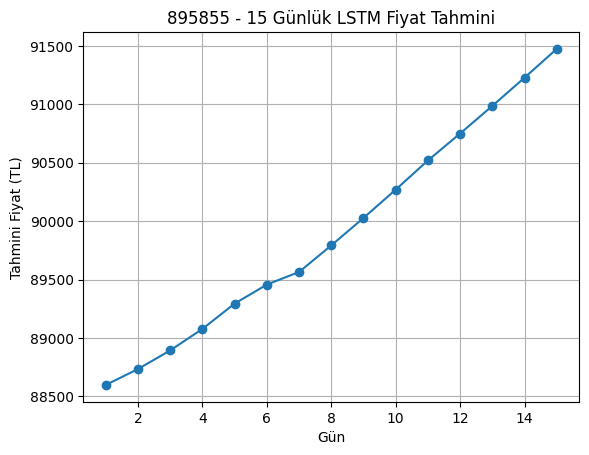

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import tensorflow as tf
import random
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

def train_and_forecast_lstm(csv_path, product_id, forecast_days=15, sequence_length=10, epochs=30):
    df_raw = pd.read_csv(csv_path)
    
    df_product = df_raw[df_raw['ProductID'] == product_id].copy()
    
    if df_product['RecordDate'].dtype == object:
        df_product['RecordDate'] = pd.to_datetime(df_product['RecordDate'], dayfirst=True, errors='coerce')
    
    df_product = df_product.dropna(subset=['RecordDate', 'Price'])
    
    df_product = df_product.sort_values('RecordDate').reset_index(drop=True)
    
    while len(df_product) < 100:
        last_date = df_product.iloc[-1]['RecordDate']
        next_date = last_date + pd.Timedelta(days=1)
        last_price = df_product.iloc[-1]['Price']
        df_product = pd.concat([df_product, pd.DataFrame({
            'ProductID': [product_id],
            'RecordDate': [next_date],
            'Price': [last_price + np.random.uniform(0, 5)]
        })], ignore_index=True)
    
    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(df_product[['Price']])
    
    X, y = [], []
    for i in range(len(scaled_prices) - sequence_length):
        X.append(scaled_prices[i:i+sequence_length])
        y.append(scaled_prices[i+sequence_length])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    model.fit(X, y, epochs=epochs, verbose=1)
    
    forecast = []
    last_sequence = scaled_prices[-sequence_length:]
    for _ in range(forecast_days):
        input_seq = last_sequence.reshape((1, sequence_length, 1))
        pred_scaled = model.predict(input_seq, verbose=0)[0][0]
        forecast.append(pred_scaled)
        last_sequence = np.append(last_sequence[1:], [[pred_scaled]], axis=0)
    
    forecast_prices = scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()
    
    print(f"ProductID: {product_id} için {forecast_days} günlük tahmin:")
    for i, price in enumerate(forecast_prices, 1):
        print(f"Gün {i}: {price:.2f} TL")
    
    plt.plot(range(1, forecast_days + 1), forecast_prices, marker='o')
    plt.title(f"{product_id} - {forecast_days} Günlük LSTM Fiyat Tahmini")
    plt.xlabel("Gün")
    plt.ylabel("Tahmini Fiyat (TL)")
    plt.grid(True)
    plt.show()

train_and_forecast_lstm("LSTMPriceHistory.csv", product_id=854787)


In [ ]:
import pandas as pd

tr_to_en = {
    "Model": "Model",
    "Ekran Boyutu": "Display Size",
    "Ekran Teknolojisi": "Display Technology",
    "Piksel Yoğunluğu": "Pixel Density",
    "Batarya Kapasitesi": "Battery Capacity",
    "Kamera Çözünürlüğü": "Camera Resolution",
    "CPU Üretim Teknolojisi": "CPU Manufacturing",
    "İşletim Sistemi": "Operating System",
    "RAM Kapasitesi": "RAM",
    "Dahili Hafıza": "Internal Storage",
    "Hızlı Şarj Desteği": "Fast Charging Support",
    "Ekran Yenileme Hızı": "Screen Refresh Rate",
    "5G": "5G",
    "Price": "Price"
}

def translate_description(desc, tr_to_en):
    if pd.isna(desc):
        return desc
    parts = desc.split(";")
    new_parts = []
    for part in parts:
        if ":" in part:
            key, val = part.split(":", 1)
            key = key.strip()
            val = val.strip()
            new_key = tr_to_en.get(key, key)  # Çeviri yoksa orijinal key
            new_parts.append(f"{new_key}: {val}")
        else:
            new_parts.append(part.strip())
    return "; ".join(new_parts)

df = pd.read_csv("orijinal.csv")

df["Description"] = df["Description"].apply(lambda x: translate_description(x, tr_to_en))

df.to_csv("yeni_english_description.csv", index=False)


In [ ]:
import pandas as pd

df = pd.read_csv(r"C:\Users\EXCALIBUR\Desktop\projects\Okul Ödevler\AIBazaar\AI\utils\notebooks\currencyRates.csv")  # openpyxl yüklü olmalı

df['RecordDate'] = pd.to_datetime(df['RecordDate'], dayfirst=True, errors='coerce')

df = df.sort_values('RecordDate').reset_index(drop=True)

df['CurrencyRate'] = df['CurrencyRate'].fillna(method='ffill')

df['RecordDate'] = df['RecordDate'].dt.strftime('%d.%m.%Y')

print(df)

df.to_csv("duzenlenmis_kur.csv", index=False)


      RecordDate  CurrencyRate
0     01.01.2021           NaN
1     02.01.2021           NaN
2     03.01.2021           NaN
3     04.01.2021        7.4194
4     05.01.2021        7.3602
...          ...           ...
1638         NaN       39.5502
1639         NaN       39.5502
1640         NaN       39.5502
1641         NaN       39.5502
1642         NaN       39.5502

[1643 rows x 2 columns]


C:\Users\EXCALIBUR\AppData\Local\Temp\ipykernel_14380\3052736928.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['CurrencyRate'] = df['CurrencyRate'].fillna(method='ffill')
